Будем пытаться построить линейную регрессию для mpg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
Auto = pd.read_csv("Auto.csv")
#Убираем пустые строки и делаем horsepower интами
Auto = Auto.replace('?', np.nan)
Auto = Auto.dropna()
Auto['horsepower'] = Auto['horsepower'].astype(int)
Auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 30.6+ KB


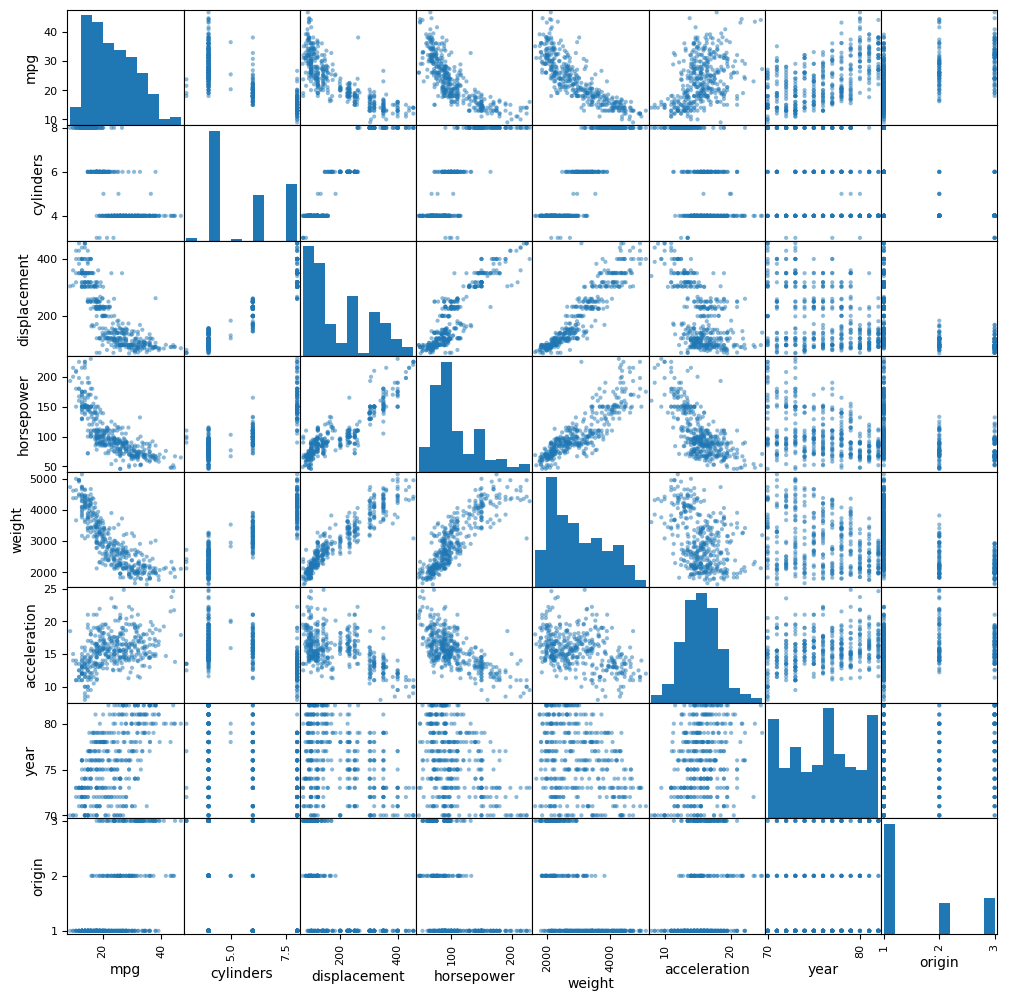

In [16]:
pd.plotting.scatter_matrix(Auto, figsize=(12, 12));

Видим что mpg имеет какую-то связь с displacement, horsepower, weight, acceleration

In [4]:
threshold = 0.9
corr_auto = Auto.select_dtypes(include=['int64', 'float64']).corr()
for a, b in itertools.combinations(corr_auto.columns, 2):
    if corr_auto.loc[a, b] > threshold:
        print(a, b)

cylinders displacement
displacement weight


В целом видно, что у нас сильно коррелируют параметры cylinders, displacement и weight, что в целом логично, давайте из всех этих штук оставим только weight.

В итоге получаем что наши параметры это - horsepwoer и weight, давайте сначала построим простую регрессию линейную по параметрам, а потом добавим квадраты или что-то еще

In [5]:
params = Auto[['horsepower', 'weight']].to_numpy()
ones = np.ones((params.shape[0], 1))
params = np.hstack([ones, params])

mpg_values = Auto[['mpg']].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    params,          # матрица признаков
    mpg_values,       # целевая переменная
    test_size=0.2,   # 20% в тест, 80% в train
    random_state=42  # для воспроизводимости
)

In [7]:
betha = np.linalg.pinv(X_train) @ y_train
betha

array([[ 4.65867414e+01],
       [-5.21467239e-02],
       [-5.87153429e-03]])

In [8]:
y_pred = X_test @ betha
#Считаем R^2
y_mean = np.mean(y_test)
TSS = np.sum(np.square(y_test - y_mean))
RSS = np.sum(np.square(y_test - y_pred))
R2 = 1 - RSS/TSS
print(R2)

0.6514190280854448


Ну в целом не норм, 0.65 не супер хорошая $R^2$. Нужно понять что мы делаем не так, давай построим residual график

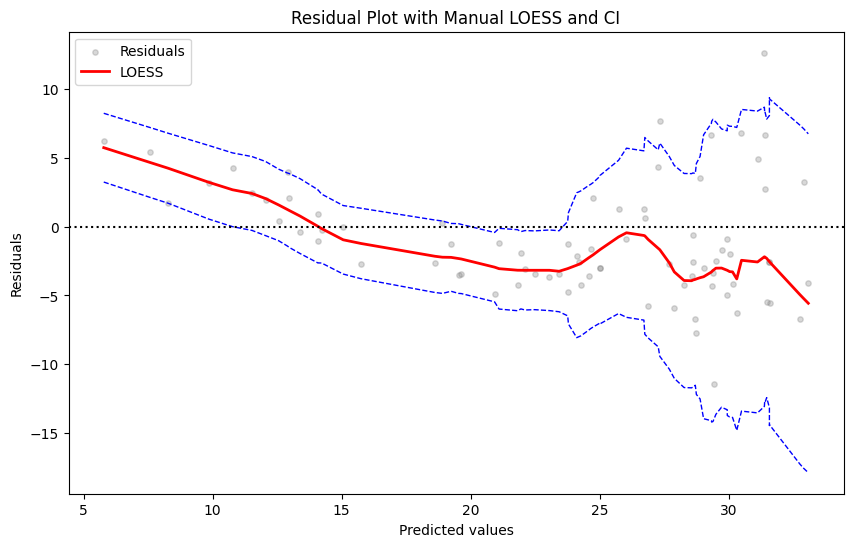

In [9]:
residuals = y_test - y_pred
y_pred = (y_pred.T).ravel()
y_test = (y_test.T).ravel()
residuals = (residuals.T).ravel()
sorted_idx = np.argsort(y_pred)
x_sorted = y_pred[sorted_idx]
res_sorted = residuals[sorted_idx]
x_sorted = x_sorted.ravel()
res_sorted = res_sorted.ravel()
smoothed = lowess(res_sorted, x_sorted, frac=0.2, return_sorted=False)

window = 30
residual_var = uniform_filter1d((res_sorted - smoothed)**2, size=window)
stderr = np.sqrt(residual_var)

ci_upper = smoothed + 2 * stderr
ci_lower = smoothed - 2 * stderr

plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, res_sorted, alpha=0.3, color='gray', s=15, label='Residuals')
plt.plot(x_sorted, smoothed, color='red', linewidth=2, label='LOESS')
plt.plot(x_sorted, ci_upper, color='blue', linestyle='--', linewidth=1)
plt.plot(x_sorted, ci_lower, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle=':')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Manual LOESS and CI")
plt.legend()
plt.show()

Мы видим U-shape в начале, а под конец что-то странное, осмелюсь предположить, что  это говорит что важна квадратичная зависимость, а так же, возможно, параметры зависят друг от друга(всмысле их вклад)

In [10]:
new_params = np.array([[param[0], param[1], param[2], param[1] * param[1], param[2] * param[2], param[1] * param[2]] for param in params])

X_train, X_test, y_train, y_test = train_test_split(
    new_params,          # матрица признаков
    mpg_values,       # целевая переменная
    test_size=0.2,   # 20% в тест, 80% в train
    random_state=42  # для воспроизводимости
)
betha = np.linalg.pinv(X_train) @ y_train
y_pred = X_test @ betha
print(betha)

[[ 6.49903323e+01]
 [-2.86895992e-01]
 [-1.01431538e-02]
 [ 3.15631843e-04]
 [ 1.73210625e-07]
 [ 3.92115708e-05]]


In [11]:
#Считаем R^2
y_mean = np.mean(y_test)
TSS = np.sum(np.square(y_test - y_mean))
RSS = np.sum(np.square(y_test - y_pred))
R2 = 1 - RSS/TSS
print(R2)

0.6883062442290293


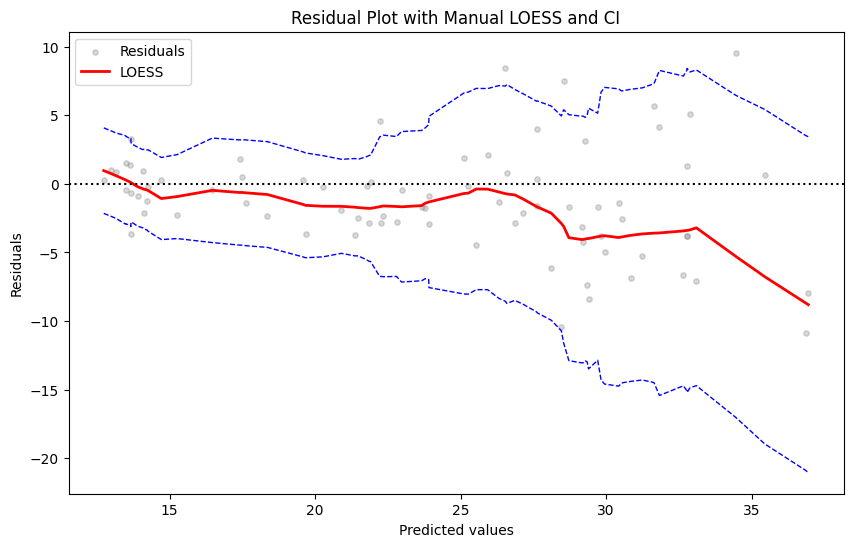

In [12]:
residuals = y_test - y_pred
y_pred = (y_pred.T).ravel()
y_test = (y_test.T).ravel()
residuals = (residuals.T).ravel()
sorted_idx = np.argsort(y_pred)
x_sorted = y_pred[sorted_idx]
res_sorted = residuals[sorted_idx]
x_sorted = x_sorted.ravel()
res_sorted = res_sorted.ravel()
smoothed = lowess(res_sorted, x_sorted, frac=0.2, return_sorted=False)

window = 30
residual_var = uniform_filter1d((res_sorted - smoothed)**2, size=window)
stderr = np.sqrt(residual_var)

ci_upper = smoothed + 2 * stderr
ci_lower = smoothed - 2 * stderr

plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, res_sorted, alpha=0.3, color='gray', s=15, label='Residuals')
plt.plot(x_sorted, smoothed, color='red', linewidth=2, label='LOESS')
plt.plot(x_sorted, ci_upper, color='blue', linestyle='--', linewidth=1)
plt.plot(x_sorted, ci_lower, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle=':')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Manual LOESS and CI")
plt.legend()
plt.show()

Можно добавить $\frac{horsepower}{weight}$ как параметр

In [13]:
new_new_params = np.array([[param[0], param[1], param[2], param[1] * param[1], param[2] * param[2], param[1] * param[2], param[1] / param[2]] for param in params])
X_train, X_test, y_train, y_test = train_test_split(
    new_new_params,          # матрица признаков
    mpg_values,       # целевая переменная
    test_size=0.2,   # 20% в тест, 80% в train
    random_state=42  # для воспроизводимости
)
betha = np.linalg.pinv(X_train) @ y_train
y_pred = X_test @ betha
print(betha)
vif = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
print(vif)

[[ 7.69396873e+01]
 [-6.66438090e-02]
 [-1.77212298e-02]
 [ 3.10490235e-04]
 [ 1.31276208e-06]
 [ 6.42287306e-06]
 [-3.48329471e+02]]
[np.float64(9156.654513999545), np.float64(4542.087190503991), np.float64(2683.755793191936), np.float64(121.92711762100875), np.float64(2807.3961029540337), np.float64(3825.1722078773973), np.float64(279.5744910336726)]


In [14]:
y_mean = np.mean(y_test)
TSS = np.sum(np.square(y_test - y_mean))
RSS = np.sum(np.square(y_test - y_pred))
R2 = 1 - RSS/TSS
print(R2)

0.6895212135358435


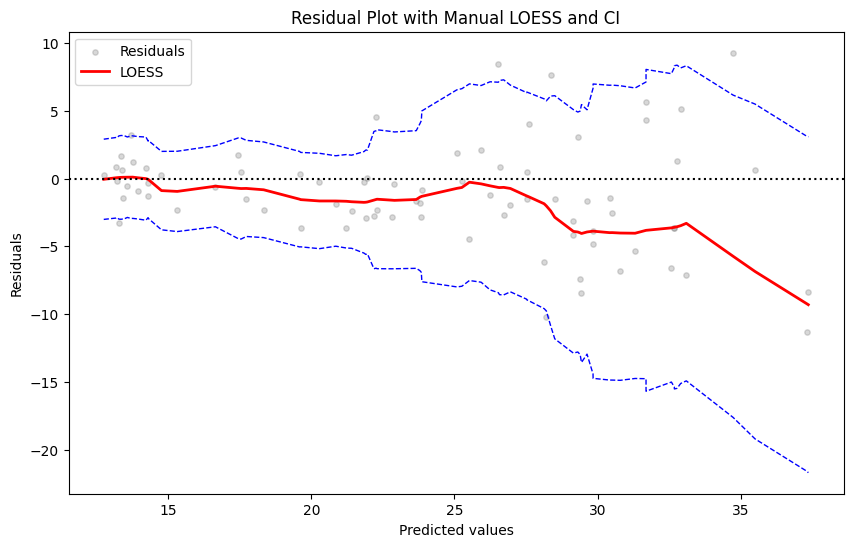

In [15]:
residuals = y_test - y_pred
y_pred = (y_pred.T).ravel()
y_test = (y_test.T).ravel()
residuals = (residuals.T).ravel()
sorted_idx = np.argsort(y_pred)
x_sorted = y_pred[sorted_idx]
res_sorted = residuals[sorted_idx]
x_sorted = x_sorted.ravel()
res_sorted = res_sorted.ravel()
smoothed = lowess(res_sorted, x_sorted, frac=0.2, return_sorted=False)

window = 30
residual_var = uniform_filter1d((res_sorted - smoothed)**2, size=window)
stderr = np.sqrt(residual_var)

ci_upper = smoothed + 2 * stderr
ci_lower = smoothed - 2 * stderr

plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, res_sorted, alpha=0.3, color='gray', s=15, label='Residuals')
plt.plot(x_sorted, smoothed, color='red', linewidth=2, label='LOESS')
plt.plot(x_sorted, ci_upper, color='blue', linestyle='--', linewidth=1)
plt.plot(x_sorted, ci_lower, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle=':')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Manual LOESS and CI")
plt.legend()
plt.show()